## Vamos utilizar todo o código já pronto, apenas atualizando a lista de times que passaram para as oitavas de final, e sucessivamente a medida que os jogos ocorram

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
from operator import itemgetter

In [4]:
with open('world_cup_sim/gb_V2.pkl' , 'rb') as f:
    gb = pickle.load(f)

In [5]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [7]:
dfs

[    0                                                  1
 0 NaN  This article documents a current FIFA World Cu...,
    كأس العالم لكرة القدم 2022Kaʾs al-ʿālam li-kurat al-qadam 2022  \
 0   .mw-parser-output .script-arabic{font-family:"...               
 1                                  Tournament details               
 2                                        Host country               
 3                                               Dates               
 4                                               Teams               
 5                                            Venue(s)               
 6                               Tournament statistics               
 7                                      Matches played               
 8                                        Goals scored               
 9                                          Attendance               
 10                                      Top scorer(s)               
 11  ← 2018 2026 → All statistics correct a

In [13]:
group_A = pd.read_html("https://en.wikipedia.org/wiki/2022_FIFA_World_Cup_Group_{}".format("A"))
len(group_A)

40

In [17]:
#print(
#    [k.head(1) for k in group_A]
#)
df_gA = group_A[0]

df_gA

Draw position         Team Pot Confederation  \
  Draw position         Team Pot Confederation   
0            A1        Qatar   1           AFC   
1            A2      Ecuador   4      CONMEBOL   
2            A3      Senegal   3           CAF   
3            A4  Netherlands   2          UEFA   

              Method ofqualification Date ofqualification Finalsappearance  \
              Method ofqualification Date ofqualification Finalsappearance   
0                              Hosts      2 December 2010              1st   
1  CONMEBOL Round Robin fourth place        24 March 2022              4th   
2            CAF Third Round winners        29 March 2022              3rd   
3               UEFA Group G winners     16 November 2021             11th   

  Lastappearance       Previous bestperformance FIFA Rankings[3]               
  Lastappearance       Previous bestperformance March 2022[nb 1] October 2022  
0              —                              —               51           50  
1           2014             Round of 16 (2006)               46           44  
2           2018          Quarter-finals (2002)               20           18  
3           2014  Runners-up (1974, 1978, 2010)               10            8

In [19]:
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
matches = []
table1 = {}
for gr_ in groups:
    html_lists = pd.read_html("https://en.wikipedia.org/wiki/2022_FIFA_World_Cup_Group_{}".format(gr_))
    group_ = html_lists[0]
    #TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
    table1[gr_] = [[a[1], 0, []] for a in list(group_.values)]
table1

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [26]:
"""
Aqui, uma tentativa SEM SUCESSO de gerar as partidas da fase de grupos, usando a biblioteca itertools e a lógica de combinatória em conjuntos tomados 2 a 2.
"""
# Import combinations from itertools
from itertools import combinations
matches1 = []
for grupo,times in table1.items():
    times_simples = [i[0] for i in times]
    matches1.extend([(grupo,i[0],i[1]) for i in list(combinations(times_simples, 2))])
    
for mat1 in matches1:
    if mat1[0]=='A':
        print(mat1)


('A', 'Qatar', 'Ecuador')
('A', 'Qatar', 'Senegal')
('A', 'Qatar', 'Netherlands')
('A', 'Ecuador', 'Senegal')
('A', 'Ecuador', 'Netherlands')
('A', 'Senegal', 'Netherlands')


In [42]:
from bs4 import BeautifulSoup
import requests 
matches2 = []
url = "https://en.wikipedia.org/wiki/2022_FIFA_World_Cup_Group_{}"
for gr_ in groups:
    page = requests.get(url.format(gr_))
    soup = BeautifulSoup(page.text,'lxml')
    a_tags = soup.find_all('a', href=True) #Find all <a> tags that have a href attr
    ponteiro = None
    for tag in a_tags:
        if tag['href']=="#Matches":
            ponteiro = tag
    times_local = [ i.get_text().split(' vs ') for i in ponteiro.parent.find('ul').find_all("span", class_="toctext") ]
    matches2.extend(
        [(gr_,i[0],i[1]) for i in times_local]
    )

matches2[:5]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal')]

In [43]:
base_df = pd.read_csv("team_stats.csv")

In [44]:
base_df.columns

Index(['date', 'team', 'score', 'suf_score', 'rank', 'rank_suf', 'rank_change',
       'total_points', 'result', 'rank_dif', 'points_by_rank', 'team_points'],
      dtype='object')

In [45]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = base_df[(base_df["team"] == team_1)].sort_values("date")
    last5 = base_df[(base_df["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [46]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [47]:
advanced_group = []
last_group = ""
thresh = 0.05

table=table1
matches=matches2

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.62 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.62 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.60 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.73 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.78 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.62 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Winner England with 0.61 probability
Group B - Wales vs. England: Winner England with 0.64 probability
Group B - Iran vs. United States: Winner United States with 0.58 probability


Group B advanced: 
England -------- 9
United

### A partir deste ponto, vamos avaliar as Oitavas de final com os times que de fato passaram para a próxima fase

In [51]:
url = "https://en.wikipedia.org/wiki/2022_FIFA_World_Cup_Group_{}"
next_stage = []
for gr_ in groups:
    html_lists = pd.read_html(url.format(gr_))
    to_next_stage = html_lists[1].values
    
    next_stage.append([to_next_stage[0][1], to_next_stage[1][1]])
next_stage

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [48]:
advanced_group

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [52]:
advanced = next_stage

In [53]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [54]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.54
Argentina vs. Australia: Argentina advances with prob 0.75
Japan vs. Croatia: Croatia advances with prob 0.59
Brazil vs. South Korea: Brazil advances with prob 0.75
Senegal vs. England: England advances with prob 0.64
Poland vs. France: France advances with prob 0.67
Spain vs. Morocco: Spain advances with prob 0.65
Switzerland vs. Portugal: Portugal advances with prob 0.57
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.51
Croatia vs. Brazil: Brazil advances with prob 0.66
England vs. France: England advances with prob 0.51
Spain vs. Portugal: Spain advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.55
England vs. Spain: England advances with prob 0.53
----------
Starting simulation of Final
----------


Braz

In [55]:
playoffs

{'Round of 16': [['Netherlands',
   'United States',
   [0.5375019854467492, 0.4624980145532508]],
  ['Argentina', 'Australia', [0.7516551935226725, 0.24834480647732746]],
  ['Japan', 'Croatia', [0.41205744170167047, 0.5879425582983295]],
  ['Brazil', 'South Korea', [0.7488767591010013, 0.25112324089899873]],
  ['Senegal', 'England', [0.36221292076258016, 0.6377870792374198]],
  ['Poland', 'France', [0.328581422645977, 0.6714185773540229]],
  ['Spain', 'Morocco', [0.6511108385146579, 0.3488891614853421]],
  ['Switzerland', 'Portugal', [0.4340056095035672, 0.5659943904964329]]],
 'Quarter-Final': [['Netherlands',
   'Argentina',
   [0.5102178589565887, 0.4897821410434113]],
  ['Croatia', 'Brazil', [0.33792449834610694, 0.6620755016538931]],
  ['England', 'France', [0.5144021513808086, 0.4855978486191915]],
  ['Spain', 'Portugal', [0.5224688162149136, 0.4775311837850864]]],
 'Semi-Final': [['Netherlands',
   'Brazil',
   [0.45453438598080714, 0.5454656140191929]],
  ['England', 'Spain', 

In [58]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

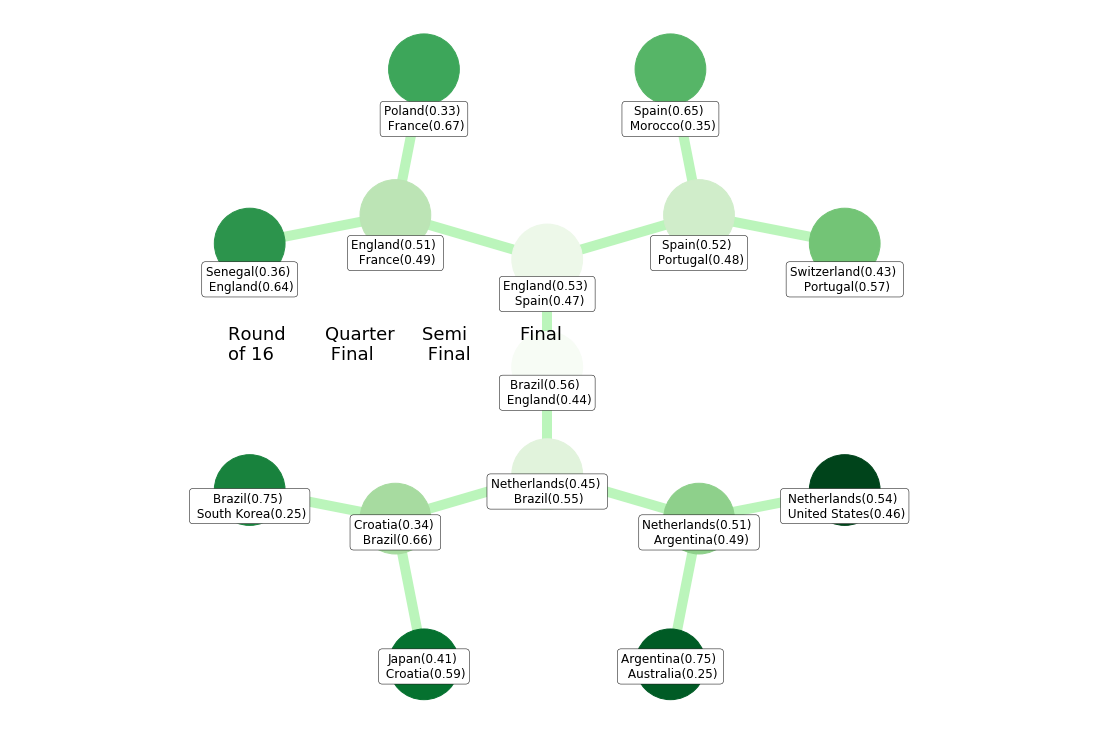

In [60]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 65 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()